# Model training: Support Vector Machine

We use Support Vector Machine to obtain our prediction model. Our model is svc from sklearn.svm. 

In [2]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Loading the data

In [5]:
path = '/Users/louispht/Dropbox/git_projects/news_classifier/Data cleaning/Pickles/'

# Dataframe
with open(path + 'df_all_noact.pickle', 'rb') as data:
    df_all = pickle.load(data)

# features_train
with open(path + 'features_train_noact.pickle', 'rb') as data:
    features_train = pickle.load(data)

# y_train
with open(path + 'y_train_noact.pickle', 'rb') as data:
    y_train = pickle.load(data)

# features_test
with open(path + 'features_test_noact.pickle', 'rb') as data:
    features_test = pickle.load(data)

# y_test
with open(path + 'y_test_noact.pickle', 'rb') as data:
    y_test = pickle.load(data)

In [6]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9771 entries, 0 to 9770
Data columns (total 7 columns):
index              9771 non-null int64
title              9771 non-null object
content            9771 non-null object
link               9771 non-null object
category           9771 non-null object
news_length        9771 non-null int64
cleaned_content    9771 non-null object
dtypes: int64(2), object(5)
memory usage: 534.5+ KB


In [7]:
features_train.shape

(8641, 500)

In [8]:
features_test.shape

(1130, 500)

In [9]:
y_train.shape

(8641,)

In [10]:
y_test.shape

(1130,)

### Randomized Search Cross Validation

In order to get the best model, we use cross validation to select some hyperparameters in the svm model. We use randomized search cross validation over Grid Search Cross validation because it is less time and computation consuming. One could use Grid Search after Randomized search once one has a better idea about the best hyperparamters one is looking for. 

In [11]:
#Hyperparameter options for the svm model
hyper_svc =svm.SVC(random_state=42)

print('Hyperparameters:\n')
print(hyper_svc.get_params())

Hyperparameters:

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


We check the documentation to understand each parameter. 

In [2]:
#help(svm.SVC)

We will tune the following hyperparameters:
'C', 'kernel', 'gamma', 'degree'

In [12]:
# Create the random grid
random_grid = {'C': [.0001, .001, .01, .1, 1.0],
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': [.0001, .001, .01, .1, 1, 10, 100],
              'degree': [1,2,3,4,5],
             }

In [13]:
# First create the base model to tune
svc = svm.SVC(random_state=42)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=42)

# Fit the random search model
random_search.fit(features_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 98.2min finished


RandomizedSearchCV(cv=3, estimator=SVC(random_state=42), n_iter=50,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1.0],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly']},
                   random_state=42, scoring='accuracy', verbose=1)

In [19]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is: % .2f" % random_search.best_score_)

The best hyperparameters from Random Search are:
{'kernel': 'poly', 'gamma': 10, 'degree': 3, 'C': 1.0}

The mean accuracy of a model with these hyperparameters is:  0.91


In [20]:
#Save the best model
best_svc = random_search.best_estimator_

In [21]:
best_svc

SVC(gamma=10, kernel='poly', random_state=42)

We fit our model.

In [22]:
best_svc.fit(features_train, y_train)

SVC(gamma=10, kernel='poly', random_state=42)

In [23]:
#predictions 
svc_pred = best_svc.predict(features_test)

### Performance Analysis

We use confusion matrix, the classification report and accuracy to analyse the performance.

In [24]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(y_train, best_svc.predict(features_train)))

The training accuracy is: 
0.9912047216757319


In [25]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(y_test, svc_pred))

The test accuracy is: 
0.8938053097345132


We see that there is potentially some overfitting. We could reduce the amount of features we have. This can also be explained by the fact that our test data were obtained for a specific day in time. So temporal changes could cause covariate shift. 

In [26]:
# Classification report
categories = {'affaires':0, 'sports':3, 'international':2, 'culture':1}
print("Classification report")
print(classification_report(y_test,svc_pred, target_names=categories))

Classification report
               precision    recall  f1-score   support

     affaires       0.85      0.90      0.88       243
       sports       0.90      0.85      0.87       274
international       0.81      0.93      0.86       220
      culture       0.98      0.90      0.94       393

     accuracy                           0.89      1130
    macro avg       0.88      0.89      0.89      1130
 weighted avg       0.90      0.89      0.89      1130



#### Confusion matrix

We first get our dataframe with the labels. 

In [27]:
# df_all_le
with open(path + 'df_all_le_noact.pickle', 'rb') as data:
    df_all_le = pickle.load(data)

In [28]:
df_all_le.head(2)

,index,title,content,link,category,news_length,cleaned_content,label_enc
0,0,"Oui, Marie-Josée Lord est une chanteuse d'opéra!",«Je ne suis pas une chanteuse d'opéra.» Marie-...,https://www.lapresse.ca/arts/festivals/montrea...,culture,3137,chanteux oper mariejos lord laiss tomb c...,1
1,1,Une vallée sans foi ni loi,C'était une paisible vallée agricole où les po...,https://www.lapresse.ca/international/amerique...,international,7051,paisibl vall agricol où polici regl chican...,2


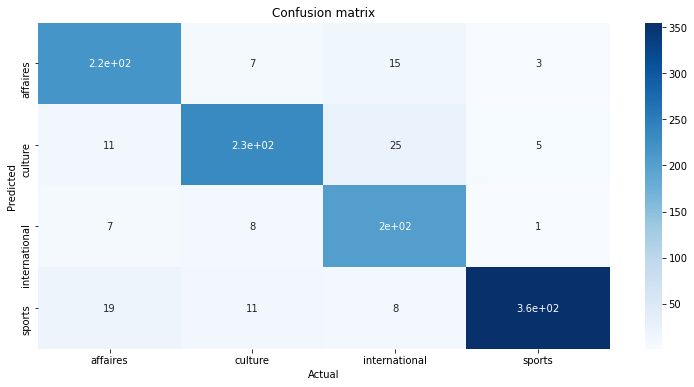

In [29]:
#Confusion matrix
aux_df = df_all_le[['category', 'label_enc']].drop_duplicates().sort_values('category')
conf_matrix = confusion_matrix(y_test, svc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['category'].values, 
            yticklabels=aux_df['category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

As expected, we see that our model has some difficulties with the 'actualites' category. This is partially due to the fact that this category is a bit more vague in terms of its content. 

#### Saving the model

In [30]:
d = {
     'Model': 'SVM',
     'Training Set Accuracy': accuracy_score(y_train, best_svc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(y_test, svc_pred)
}

df_models_svc = pd.DataFrame(d, index=[0])

In [31]:
df_models_svc

,Model,Training Set Accuracy,Test Set Accuracy
0,SVM,0.991205,0.893805


In [32]:
with open('Models/best_svc_noact.pickle', 'wb') as output:
    pickle.dump(best_svc, output)
    
with open('Models/df_models_svc_noact.pickle', 'wb') as output:
    pickle.dump(df_models_svc, output)

#### Looking at some fail classification

In [33]:
# df_test
with open(path + 'df_test_noact.pickle', 'rb') as data:
    df_test = pickle.load(data)

In [34]:
df_test

,index,title,content,link,category,news_length,cleaned_content
0,175,Deux militaires français tués en opération dan...,(Paris) Deux militaires de la force française ...,https://www.lapresse.ca/international/afrique/...,international,4408,paris deux militair forc français sahel bar...
1,176,Le chef rebelle libyen Khalifa Haftar attaqué ...,Le chef rebelle libyen Khalifa Haftar est atta...,https://www.lapresse.ca/international/afrique/...,international,5737,chef rebel libyen khalif haftar attaqu just...
2,177,Rwanda: les zones d’ombre de l’arrestation du ...,(Nairobi) L’arrestation dans des circonstances...,https://www.lapresse.ca/international/afrique/...,international,5294,nairob arrest circonst troubl héros film h...
3,178,RDC: plus de 24 000 personnes déplacées par le...,(Genève) Plus de 24 000 personnes ont été dépl...,https://www.lapresse.ca/international/afrique/...,international,2375,genev plus 24000person déplac depuis mois ...
4,179,Le héros du film Hôtel Rwanda arrêté pour terr...,(Kigali) L’homme présenté comme un héros dans ...,https://www.lapresse.ca/international/afrique/...,international,2283,kigal homm présent comm héros film hôtel rw...
...,...,...,...,...,...,...,...
1125,1467,Drôles de souvenirs à «Cuvée comique»,MONTRÉAL – Philippe Laprise reçoit des humoris...,https://www.journaldemontreal.com/2020/08/03/d...,culture,3191,montréal – philipp lapris reçoit humor compli...
1126,1468,Dieudonné banni de Facebook et Instagram,PARIS | Le groupe Facebook a annoncé lundi avo...,https://www.journaldemontreal.com/2020/08/03/h...,culture,2256,paris | group facebook annonc lund avoir ban...
1127,1469,Les blagues de Mike Ward en Cour suprême,La Cour suprême du Canada accepte de juger si ...,https://www.journaldemontreal.com/2020/07/30/m...,culture,2588,cour suprêm canad accept jug si blagu crue...
1128,1470,Jérémy Gabriel accepte la décision,Jérémy Gabriel aurait préféré que la demande d...,https://www.journaldemontreal.com/2020/07/30/m...,culture,1035,jérémy gabriel préfer demand appel mik war...


In [35]:
from IPython.display import display
id_to_category = dict(aux_df[['label_enc', 'category']].values)
for predicted in aux_df.label_enc:
    for actual in aux_df.label_enc:
        if predicted != actual and conf_matrix[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_matrix[actual, predicted]))
            display(df_test.loc[(y_test == actual) & (svc_pred == predicted)][['title', 'category', 'content']].sample(10))
            print('')

'culture' predicted as 'affaires' : 11 examples.


,title,category,content
1108,Des musées ouverts seulement en juin,culture,Même si les musées ont obtenu le feu vert pour...
561,Une fille pour Katy Perry et Orlando Bloom,culture,(Montréal) Katy Perry a donné naissance à une ...
1063,Kim Gingras dévoile les secrets de sa carrière,culture,Comment arrive-t-on à danser avec les plus gra...
1068,Cœur de pirate veut acheter sa maison de disq...,culture,La chanteuse Cœur de pirate souhaite acheter l...
1095,Une firme indépendante pour examiner la situa...,culture,Le congédiement de la directrice générale du M...
1096,"«Mon congédiement, c’est du salissage, vraime...",culture,"MONTRÉAL – Congédiée lundi, l’ancienne directr..."
515,Une projection 3D à Cap Canaveral pour le Québ...,culture,"(Montréal) Le Québécois Philippe Bergeron, qui..."
1106,La Ronde: les clients devront réserver leur p...,culture,MONTRÉAL | La Ronde attend toujours l'autorisa...
578,Des stratégies inhabituelles au cinéma,culture,Deux films plusieurs fois repoussés en raison ...
479,Bell supprime sa subvention francophone à un f...,culture,Bell Média met la hache dans le financement de...



'sports' predicted as 'affaires' : 19 examples.


,title,category,content
981,Saison terminée dans les stations de ski,sports,L’Association des stations de ski du Québec (A...
882,De nouveaux sites dédiés aux jeunes chasseurs,sports,Considérant à juste titre que la chasse du pet...
896,Théâtre Capitole: une scène transformée en ring,sports,Après avoir accueilli des centaines de vedette...
894,Enregistrement en ligne des gibiers,sports,"Dès le 5 septembre, les chasseurs d’orignaux e..."
895,Des opportunités vraiment inattendues,sports,"Année après année, un pourcentage très élevé d..."
968,Les stations de ski se préparent pour l’hiver,sports,Bien que les autorités en santé publique du Qu...
891,Chasser en sécurité cet automne,sports,Si vous chassez cet automne dans une réserve f...
423,Michael Jordan investit dans un site de pari s...,sports,(New York) L’ex-vedette des Bulls de Chicago M...
883,L’expertise des pourvoiries pour les chasseurs,sports,L’expertise des pourvoyeurs est un précieux at...
892,Nouvelle saison de chasse du chevreuil,sports,"Depuis le temps qu’elle était attendue, la fin..."



'sports' predicted as 'culture' : 11 examples.


,title,category,content
889,Une initiative qui plaira aux familles,sports,"En vertu des nouvelles modalités de chasse, le..."
363,« Copie » en F1 : Renault veut du changement a...,sports,(Spa-Francorchamps) À la suite de l’affaire de...
887,À la découverte du réseau des zecs,sports,Plusieurs points militent en faveur des zecs d...
975,Un pionnier du ski de fond meurt à l’âge de 8...,sports,Les fondeurs qui ont goûté au Refuge de Saint-...
868,LDT a craint pour sa bague du Super Bowl,sports,Le célèbre joueur de football québécois Lauren...
276,JO-2028 : le logo dévoilé met en avant la dive...,sports,(Los Angeles) Les organisateurs des Jeux olymp...
877,Colin Kaepernick au Temple de la renommée?,sports,Après avoir découvert que tous pouvaient soume...
970,De coach de l’élite à aide de service,sports,Après avoir passé du temps de qualité en famil...
361,Hamilton partira premier au GP de Belgique,sports,(Spa-Francorchamps) Le Britannique Lewis Hamil...
367,"Hamilton « fier » des athlètes américains, mai...",sports,"(Spa-Francorchamps) Lewis Hamilton, seul pilot..."



'affaires' predicted as 'international' : 15 examples.


,title,category,content
118,La pandémie pourrait donner le « baiser de la ...,affaires,(Genève) La pandémie de coronavirus a accru la...
169,Facebook et Twitter démantèlent une petite cam...,affaires,(San Francisco) Facebook et Twitter ont de nou...
172,TikTok se conformera à la nouvelle réglementat...,affaires,"(Pékin) Le groupe chinois ByteDance, propriéta..."
177,Décès du magnat américain des médias Sumner Re...,affaires,(New York) Le magnat américain des médias Sumn...
183,Meredith Kopit Levien deviendra PDG du New Yor...,affaires,(New York) Déjà numéro deux opérationnelle du ...
163,Chine: Apple clarifie sa politique sur la libe...,affaires,(Paris) Accusé par des ONG et investisseurs d’...
123,"Décès de David Graeber, figure de proue d’Occu...",affaires,(New York) L’anthropologue américain David Gra...
168,Donald Trump ne lâche rien sur la vente de TikTok,affaires,(San Francisco) Donald Trump a réitéré mardi s...
191,Australie: Facebook refuse de partager avec le...,affaires,(Sydney) Facebook a rejeté lundi les appels du...
161,Le Pentagone réaffirme son choix de Microsoft ...,affaires,(San Francisco) Le ministère de la Défense amé...



'culture' predicted as 'international' : 25 examples.


,title,category,content
519,Un tableau de Frans Hals volé pour la 3e fois,culture,(La Haye) Un tableau du grand maître de l’âge ...
1019,Appel au boycottage du nouveau «Mulan»,culture,Les militants prodémocratie de Hong Kong ont r...
558,Le monde selon Adib,culture,(Paris) La chaîne YouTube du polémiste françai...
562,Kanye West sur le bulletin de vote du Tennessee,culture,(Montréal) Le rappeur et producteur Kanye West...
509,Propos sur les personnes transgenres: J. K. Ro...,culture,(Londres) L’écrivaine britannique J. K. Rowlin...
1036,Harold Fortin se joint à «La Joute»,culture,L’ancien conseiller libéral Harold Fortin et l...
566,Britney Spears ne veut plus être sous tutelle ...,culture,(Los Angeles) La vedette américaine de la pop ...
518,Des New-Yorkais retrouvent avec joie un MoMA q...,culture,(New York) Savourer en toute tranquillité de c...
557,La chaîne YouTube de Dieudonné supprimée,culture,(Paris) La chaîne YouTube du polémiste françai...
569,Joe Biden appelle Cardi B à faire voter les je...,culture,(New York) Preuve que le vote des jeunes est e...


A lot of these misclassifications make intuitive sense, to the point where a human would probably have trouble classifying them correctly. 